# Analysis Purpose

The purpose of this analysis project is to identify key board members who have connections with potential buyers in the USA, thereby selling the company, Morris Inc. PLC. Two datasets extracted from DEF 14A fillings from US companies and one complementary dataset were analyzed for this purpose, particularly using network analysis and clustering techniques.

# 1. Library Import

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx
import networkx.algorithms
from scipy.stats import spearmanr
from sklearn.metrics import silhouette_score
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import sklearn.cluster
import sklearn.preprocessing
import time
import warnings
warnings.filterwarnings("ignore")

# 2. Data Import and Preprocess

### 2.1. Dataset 1: company directorships

In [2]:
df = pd.read_csv('company_directorships.csv')

df.software_background = df.software_background.map(lambda x: x == 't')

df.sample(5)

,company_name,cikcode,director_name,software_background,start_date,end_date
9791,QUAKER CHEMICAL CORP,81362,MICHAEL J. SHANNON,False,2020-03-31,2023-03-31
8125,MESA LABORATORIES INC /CO/,724004,"JOHN J. SULLIVAN, PH.D.",False,2009-08-03,2018-09-20
12234,UNIFIRST CORP,717954,CYNTHIA CROATTI,False,2008-12-09,2024-12-05
10418,SEABOARD CORP /DE/,88121,STEVEN J. BRESKY,False,2005-03-14,2020-03-13
11366,SYSCO CORP,96021,JOSHUA D. FRANK,False,2017-10-06,2020-10-07


### 2.2. Dataset 2: director details

< Import dataset and group data by name >

In [3]:
compensation_and_demographics_raw = pd.read_csv('director-details.csv')
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

def most_common(series):

    mode_values = series.mode()

    if len(mode_values) > 0:

        return mode_values[0]
    
    return None

compensation_and_demographics = pd.DataFrame({

    'age': compensation_and_demographics_raw.groupby('NAME').age.max(),
    'compensation': compensation_and_demographics_raw.groupby('NAME').compensation.sum(),
    'gender': compensation_and_demographics_raw.groupby('NAME').gender.agg(most_common)

})

compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)
compensation_and_demographics.head()

,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139


< Create age groups >

In [4]:
# Check age range

compensation_and_demographics['age'].unique()

array([ 64,  70,  80,  52,  78,  67,  79,  60,  62,  44,  53,  46,  42,
        51,  71,  61,  63,   0,  38,  50,  49,  57,  76,  68,  43,  65,
        81,  55,  66,  58,  73,  87,  48,  56,  85,  72,  59,  83,  74,
        69,  45,  75,  47,  54,  35,  41,  90,  89,  40,  91,  82,  93,
        36,  86,  39,  88,  37,  77,  34,  84,  94,  29, 103,  27,  33,
        22,  92,  30], dtype=int64)

In [5]:
# Create nine age groups

compensation_and_demographics = compensation_and_demographics[compensation_and_demographics['age'] >= 20]

compensation_and_demographics['age_group'] = pd.cut(
    
    compensation_and_demographics['age'], 
    bins = [20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 
    right = False, 
    labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s'])

compensation_and_demographics = compensation_and_demographics[compensation_and_demographics['age'] >= 20]

print(compensation_and_demographics[['age', 'age_group']].head(10))

                          age age_group
NAME                                   
A. CATHERINE NGO           64       60s
A. EUGENE WASHINGTON       70       70s
A. F. PETROCELLI           80       80s
A. FARAZ ABBASI            52       50s
A. LARRY CHAPMAN           78       70s
A. LOUIS PARKER            67       60s
A. RUSSELL CHANDLER, III   79       70s
A. SCOTT MOBLEY            60       60s
A. SHANE SANDERS           62       60s
A.G. SULZBERGER            44       40s


-> Based on the age distribution, nine age groups were created for analysis.

### 2.3. Dataset 3: acquiring tech companies

- This dataset contains information on M&A in the USA IT industry with board member names of acquiring big IT companies. This dataset will used to identify what companies can be connected through certain board members. Board members and their company names that exist in three datasets will be identified. It is assumed that connecting the board members may have connections with their companies' acquired IT companies. Detailed analysis is in section 5 "Connectable Companies".
- Link: https://www.kaggle.com/datasets/joebeachcapital/technology-mergers-and-acquisitions?resource=download

In [6]:
df_acquiring = pd.read_csv('Acquiring Tech Companies.csv', encoding = 'ISO-8859-1')
df_acquiring.head(5)

,Acquiring Company,Number of Acquisitions,Board Members,Country (HQ),Acquired Companies
0,Amazon,45,"Gervase Clifton-Bligh, Patricia Q. Stonesifer,...",United States,"AbeBooks, Accept.Com, Alexa, Amie Street, Audi..."
1,AOL,62,"David Bell, Susan Lyne, Jim Wiatt, Fred Reynol...",United States,"5min Media, Adap.tv, ADTECH, Advertising.com, ..."
2,Apple,51,"Robert A. Iger, Al Gore, Gareth C.C. Chang, Cl...",United States,"AlgoTrim, Anobit Technologies, AuthenTec, Beat..."
3,AT&T,12,"Nathen Harvey, Gilbert F. Amelio, Nigel Vaz, R...",United States,"Centennial Communications Corp, Dobson Communi..."
4,Cisco Systems,162,"Greg Brown, Carol Bartz, Jim Gibbons, Gilles d...",United States,"Active Voice Corporation, Actona Technologies,..."


< 2.3.1. Split board member names >

In [7]:
# Split board member names and add each name to the original dataset in different columns

board_members_split = df_acquiring['Board Members'].str.split(',', expand = True)
board_members_split_columns = [f"Board Member {i+1}" for i in range(board_members_split.shape[1])]
board_members_split.columns = board_members_split_columns
df_acquiring = df_acquiring.drop(columns = ['Board Members']).join(board_members_split)

In [8]:
df_acquiring.head(1)

,Acquiring Company,Number of Acquisitions,Country (HQ),Acquired Companies,Board Member 1,Board Member 2,Board Member 3,Board Member 4,Board Member 5,Board Member 6,...,Board Member 13,Board Member 14,Board Member 15,Board Member 16,Board Member 17,Board Member 18,Board Member 19,Board Member 20,Board Member 21,Board Member 22
0,Amazon,45,United States,"AbeBooks, Accept.Com, Alexa, Amie Street, Audi...",Gervase Clifton-Bligh,Patricia Q. Stonesifer,Thomas O. Ryder,Myrtle S. Potter,Bing Gordon,John Doerr,...,None,None,None,None,None,None,None,None,None,None


# 3. EDA & Board Member Selection Criteria

### 3.1. Identify the number of companies that each board member serves

In [9]:
directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
directorship_counts.head()

director_name
A CHARLENE SULLIVAN, PH.D.    1
MICHAEL L. KUTA               1
MICHAEL L. LARUSSO            1
MICHAEL L. MILLER             1
MICHAEL L. OWENS              1
Name: company_name, dtype: int64

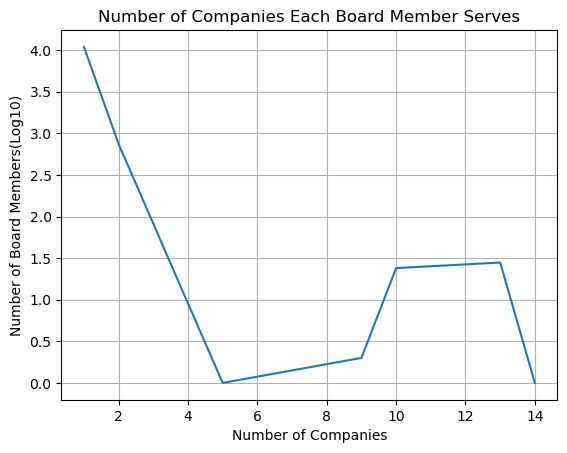

In [10]:
distribution = directorship_counts.value_counts().sort_index()

plt.plot(distribution.index, np.log10(distribution.values))
plt.xlabel('Number of Companies')
plt.ylabel('Number of Board Members(Log10)')
plt.title('Number of Companies Each Board Member Serves')
plt.grid(True)
plt.show()

-> The majority of board members are affiliated with only one or two companies. A few members are affiliated with more than 10 companies, representing more than 10 individuals. 

### 3.2. Identify the proportion of gender

In [11]:
compensation_and_demographics.gender.value_counts(dropna = False)

gender
male      3749
female    1526
None        19
Name: count, dtype: int64

-> The number of male members is significantly more than female members.

### 3.3. Identify associations between age and number of companies 

< Visualize the number of board members by age group >

In [12]:
# Print the number of board members by age group 

compensation_and_demographics.age_group.value_counts(dropna = False)

age_group
60s     2418
50s     1267
70s     1121
40s      284
80s      155
30s       31
90s       14
20s        3
100s       1
Name: count, dtype: int64

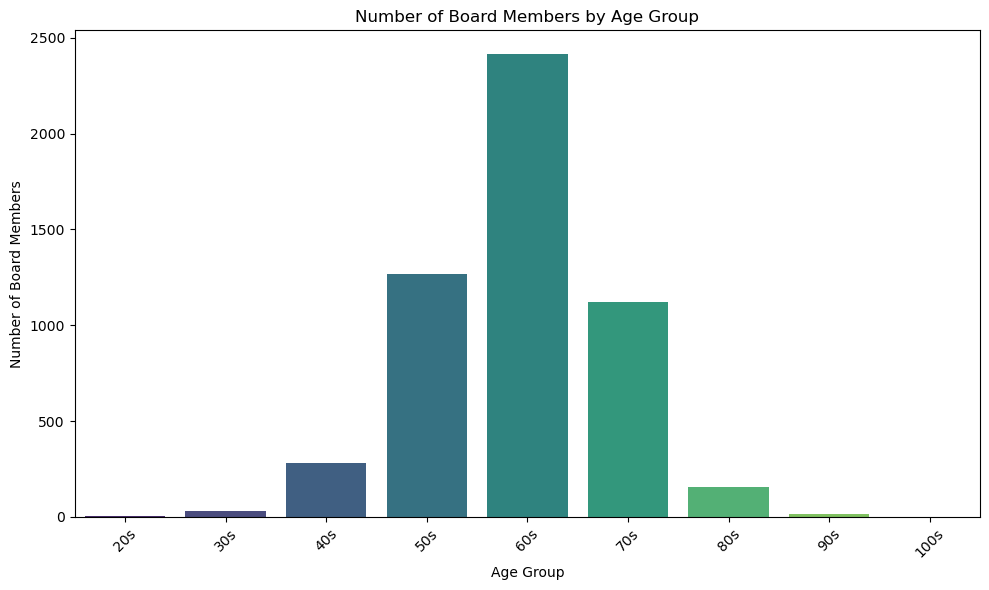

In [13]:
# Visualize number of members by age group

age_counts = compensation_and_demographics['age_group'].value_counts().sort_index()

plt.figure(figsize = (10,6))
sns.barplot(x = age_counts.index, y = age_counts.values, palette = 'viridis')

plt.title('Number of Board Members by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Board Members')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

-> Most board members are in the age groups of the 50s, 60, and 70s. Then, only three and one board memebers are in the groups of 20s and 100s respectively.

< Identify average number of companies that each board member is affiliated by age group >

In [14]:
# Make a dataframe with directorship_df

directorship_df = directorship_counts.to_frame(name = 'num_companies_serve')

directorship_age_group = directorship_df.join(compensation_and_demographics[['age_group']])

# Identify average number of companies by age group

avg_num = directorship_age_group.groupby('age_group')['num_companies_serve'].mean().sort_values(ascending = False)

print("Average number of companies by age:\n", avg_num)

Average number of companies by age:
 age_group
70s     1.201452
80s     1.193548
60s     1.189109
30s     1.100000
50s     1.090323
90s     1.071429
40s     1.042857
20s     1.000000
100s    1.000000
Name: num_companies_serve, dtype: float64


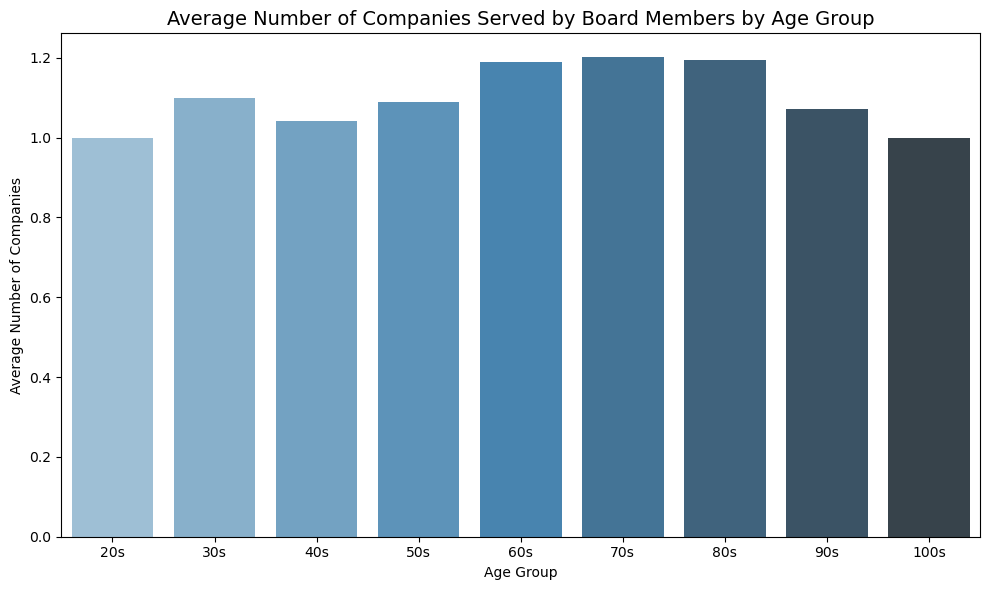

In [15]:
plt.figure(figsize = (10, 6))

sns.barplot(x = avg_num.index, y = avg_num.values, palette = "Blues_d")

plt.title('Average Number of Companies Served by Board Members by Age Group', fontsize = 14)
plt.xlabel('Age Group')
plt.ylabel('Average Number of Companies')
plt.xticks(rotation = 360)
plt.tight_layout()
plt.show()

-> Based on the results, board members in the age groups of the 60s, 70s, and 80s are more likely to serve at more companies compared to the other age groups. To determine whether the differences are statistically significant, ANOVA test or Kruskal-Wallis test should be conducted. 

< Conduct Shapiro test to assess normality >

In [16]:
# Filter age groups having more than three data for Shapiro test

groups_filtered = [group['num_companies_serve'].values 
                   for name, group in directorship_age_group.groupby('age_group') 
                   if len(group) >= 3]
group_names_filtered = [name for name, group in directorship_age_group.groupby('age_group') if len(group) >= 3]

# Assess normality

from scipy.stats import shapiro

for name, group in zip(group_names_filtered, groups_filtered):
    stat, p = shapiro(group)
    print(f"{name}: Shapiro-Wilk p-value = {p:.4f}")

20s: Shapiro-Wilk p-value = 1.0000
30s: Shapiro-Wilk p-value = 0.0000
40s: Shapiro-Wilk p-value = 0.0000
50s: Shapiro-Wilk p-value = 0.0000
60s: Shapiro-Wilk p-value = 0.0000
70s: Shapiro-Wilk p-value = 0.0000
80s: Shapiro-Wilk p-value = 0.0000
90s: Shapiro-Wilk p-value = 0.0000


-> The number of board members aged over 100 is less than three so Shapiro test cannot be applied to assess normality. Except for the age group 20s, the other age groups do not follow a normal distribution, indicating that Kruskal-Wallis test should be applied to determine whether the differences in the number of companies across age groups are statistically significant.   

< Conduct Kruskal-Wallis test >

In [17]:
groups_filtered = [group['num_companies_serve'].values for name, group in directorship_age_group.groupby('age_group') if len(group) >= 3]

stat, p = kruskal(*groups_filtered)

print(f"Kruskal-Wallis test p-value = {p:.4f}")

Kruskal-Wallis test p-value = 0.0000


-> According to the Kruskal-Wallis test, the differences in the number of companies across age groups are statistically significant. Therefore, board members aged between 60 and 79 serve at more companies, indicating there might be more opportunities to sell the company.  

### 3.4. Assess association between compensation and number of companies 

In [18]:
company_counts_df = directorship_counts.reset_index()
company_counts_df.columns = ['director_name', 'number_of_companies']

merged_df = pd.merge(

    compensation_and_demographics,
    company_counts_df,
    left_index = True,
    right_on = 'director_name',
    how = 'left'

)

subset = merged_df[['number_of_companies', 'log_compensation']].dropna()
corr, p = spearmanr(subset['number_of_companies'], subset['log_compensation'])

print(f"Spearman correlation: {corr:.3f}, p-value: {p:.4f}")

Spearman correlation: 0.267, p-value: 0.0000


Text(0, 0.5, 'Log Compensation')

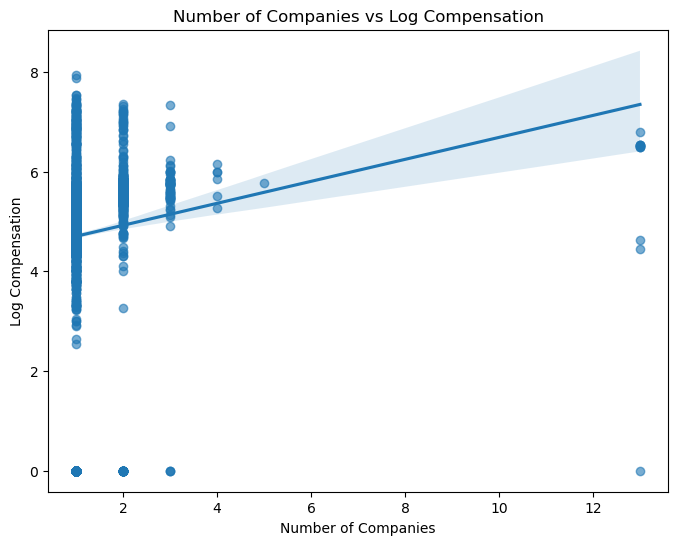

In [19]:
# Visualize the correlation

plt.figure(figsize = (8,6))

sns.regplot(x = 'number_of_companies', y = 'log_compensation', data=subset, scatter_kws = {'alpha':0.6})

plt.title('Number of Companies vs Log Compensation')
plt.xlabel('Number of Companies')
plt.ylabel('Log Compensation')

-> According to the Spearman correlation test, there is a positive correlation between compensation and number of companies. In other words, board members with high compensations tend to serve at more companies.

# 4. Network Analysis

### 4.1. Calculate network centrality

< Calculate each board member's three centrality measure scores >

In [20]:
graph = networkx.Graph()

In [21]:
people = []
companies = []

for company_name, director_name in zip(df.company_name, df.director_name):
    graph.add_edge(company_name, director_name)
    people.append(director_name)
    companies.append(company_name)

In [22]:
biggest_connected_graph = graph.subgraph(list(networkx.connected_components(graph))[0])

#### *Importance of betweenness centrality
Betweenness centrality measure is significant in identifying potential brokers who can assist with selling the company. They are well-connected across various companies and control information on the communication pathes between other board members as a mediator. Since board members with high betweenness centrality have influence in their networks, their networks and insights are valuable for identifying potential buyers that meet the desired criteria. It may take a long time to sell a startup company without networks and information. Brokers can accelerate the sales process and save time by addressing the barriers. They know the demand for the company and its technology in their networks and they have significant influence in their networks. Therefore, looking for board members with high betweenness centrality is one of the approaches to sell the company rapidly. 

#### *Importance of degree centrality
Degree centrality measure is significant in identifying individuals who have broad networks, indicating that making connections with board members with high degree centrality has benefits in spreading and attaining the latest information in the industry. However, degree centrality measure has limitations in assessing their influence and understanding their importance in their networks. 

#### *Importance of eigenvector centrality
Eigenvector centrality measure is significant in identifying individuals who hold influential decision-making power. Board members with high eigenvector centrality can directly impact business decisions since they are connected with influential individuals. Therefore, making connections with these people can help accelerate the sales process and should be the most rapid way to sell the company. Accordingly, one of the most effective approaches for this project is to identify board members who exhibit high degree and eigenvector centrality. 

< Calculate centrality scores and merge the scores >

In [23]:
start = time.time()

centrality = pd.DataFrame({

    'eigen': pd.Series(networkx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pd.Series(networkx.algorithms.degree_centrality(biggest_connected_graph)),
    'betweenness': pd.Series(networkx.betweenness_centrality(biggest_connected_graph)),
    
})

centrality['is_person'] = centrality.index.map(lambda x: x in people)

end = time.time()

print(f"Execution time: {end - start:.4f} seconds")

Execution time: 357.3696 seconds


In [24]:
people_df = centrality[centrality.is_person].merge(compensation_and_demographics, left_index = True, right_index = True)

people_df = people_df.reset_index()

people_df = people_df.rename(columns = {'index': 'name'})

people_df = people_df.merge(df[['director_name', 'company_name']], 
                            left_on = 'name', 
                            right_on = 'director_name', 
                            how = 'left')

people_df = people_df.drop(columns = ['director_name'])

people_df.head()

,name,eigen,degree,betweenness,is_person,age,compensation,gender,log_compensation,age_group,company_name
0,CHRISTOPHER J. MURPHY III,2.653687e-20,0.000122,0.0,True,78,0,male,0.000000,70s,1ST SOURCE CORP
1,CHRISTOPHER J. MURPHY IV,2.653687e-20,0.000122,0.0,True,55,123120,male,5.090332,50s,1ST SOURCE CORP
2,DANIEL B. FITZPATRICK,2.653687e-20,0.000122,0.0,True,67,165620,male,5.219115,60s,1ST SOURCE CORP
3,ISAAC P. TORRES,2.653687e-20,0.000122,0.0,True,57,166620,male,5.221730,50s,1ST SOURCE CORP
4,JOHN F. AFFLECK-GRAVES,2.653687e-20,0.000122,0.0,True,74,127620,male,5.105922,70s,1ST SOURCE CORP


-> The result shows each board member's three centrality scores. 

### 4.2. Identify key board members based on centrality measures

< Identify the top 20 board members having high eigenventor and degree centrality >

In [25]:
# Filter top 20% of board members based on eigenvector centrality and degree centrality

eigen_threshold = people_df['eigen'].quantile(0.8)
degree_threshold = people_df['degree'].quantile(0.8)

top_people = people_df[
    (people_df['eigen'] >= eigen_threshold) & 
    (people_df['degree'] >= degree_threshold)
]

# Remove duplicate board members
# A board member can serve at multiple companies, so drop duplicate board members to keep only one occurrence of each board member

top_people_unique = top_people.drop_duplicates(subset = 'name')

top_people_unique = top_people_unique.dropna(subset=['log_compensation'])

# For each company, retain the board member with the highest compensation
# If multiple board members belong to the same company, keep the one with the highest log compensation

top_people_unique_companies = top_people_unique.loc[
    top_people_unique.groupby('company_name')['log_compensation'].idxmax()
]

# Sort board members based on the three centrality measures

top20 = top_people_unique_companies.sort_values(by = ['eigen', 'degree', 'betweenness'], ascending = False).head(20)

top20_result = top20[['name', 'eigen', 'degree', 'age', 'log_compensation', 'company_name']]

top20_result


,name,eigen,degree,age,log_compensation,company_name
2519,BETH ANN BROWN,1.024389e-01,0.001585,56,6.803717,Invesco Advantage Municipal Income Trust II
2985,STEVEN L. PACKEBUSH,3.256530e-07,0.000244,59,5.565864,"LSB INDUSTRIES, INC."
81,MARRAN H. OGILVIE,3.250755e-07,0.000244,55,5.368631,"Accelerate Diagnostics, Inc"
2001,MICHAEL J. HAPPE,3.210636e-07,0.000244,53,5.397942,FULLER H B CO
338,ROBERT E. ROBOTTI,1.148967e-09,0.000366,71,5.474181,AMREP CORP.
1749,LEE M. CANAAN,1.147030e-09,0.000244,67,5.739419,EQT Corp
3496,JOHN H. PINKERTON,1.146951e-09,0.000244,70,5.277742,PHX MINERALS INC.
1182,M. JAY ALLISON,2.030343e-12,0.000244,68,6.996343,COMSTOCK RESOURCES INC
4117,DICK FAGERSTAL,2.026920e-12,0.000244,63,5.507734,TIDEWATER INC
2130,MARK W. SHEAHAN,1.919811e-12,0.000244,61,6.931258,GRACO INC


-> The result shows key board members to contact for making connections with potential buyers. They have broad networks and significant impact on decision-makings. More contact options were ensured by removing duplicate names and selecting only one member with the highest compensation from each company. Compensation was chosen as the selection criterion because it has been found that compensation has a positive association with the number of companies a member is involved with.

< Identify the top 20 board members having high betweenness centrality >

In [26]:
# Filter top 20% of board members based on betweenness centrality 

betweenness_threshold = people_df['betweenness'].quantile(0.8)

top_people = people_df[
    (people_df['betweenness'] >= betweenness_threshold)
]

# Remove duplicate board members based on person name
# A board member can serve at multiple companies, so drop duplicate board members to keep only one occurrence of each board member

top_people_unique = top_people.drop_duplicates(subset = 'name')

top_people_unique = top_people_unique.dropna(subset=['log_compensation'])

# For each company, retain the board member with the highest compensation
# If multiple board members belong to the same company, keep the one with the highest log compensation

top_people_unique_companies = top_people_unique.loc[
    top_people_unique.groupby('company_name')['log_compensation'].idxmax()
]

# Sort board members based on betweenness centrality measures

top20 = top_people_unique_companies.sort_values(by = ['betweenness'], ascending = False).head(20)

top20_result = top20[['name', 'betweenness', 'age', 'log_compensation', 'company_name']]

top20_result


,name,betweenness,age,log_compensation,company_name
2871,KERRII B. ANDERSON,0.030179,66,5.743909,LANCASTER COLONY CORP
2076,PAUL D. DONAHUE,0.028527,68,6.916454,GENUINE PARTS CO
1685,MARK A. BLINN,0.026345,63,5.774499,EMERSON ELECTRIC CO
2001,MICHAEL J. HAPPE,0.025681,53,5.397942,FULLER H B CO
1079,ALEXIS M. HERMAN,0.025558,74,5.823533,COCA COLA CO
1276,DONNA W. HYLAND,0.022467,64,5.736612,COUSINS PROPERTIES INC
516,LINNIE M. HAYNESWORTH,0.021011,67,6.012356,AUTOMATIC DATA PROCESSING INC
822,J. STEVEN WHISLER,0.020681,70,5.856627,BRUNSWICK CORP
187,ALEXIS P. MICHAS,0.019988,67,5.758138,ALLIENT INC
1807,MICHAEL H. KEOWN,0.019078,62,5.327373,FARMER BROTHERS CO


-> The result shows board members who can play as brokers. They may offer various options to sell the company depending on situations. More contact options were ensured by removing duplicate names and selecting only one member with the highest compensation from each company. Compensation was chosen as the selection criterion because it has been found that compensation has a positive association with the number of companies a member is involved with. 

### 4.3. Assess centrality difference by gender

< Assess normality of the centrality scores by gender >

In [27]:
for gender in ['male', 'female']:

    subset = people_df[people_df['gender'] == gender]

    print(f"\n--- {gender.upper()} ---")
    
    for metric in ['eigen', 'degree', 'betweenness']:
        stat, p = shapiro(subset[metric])
        result = "normality ✅" if p > 0.05 else "no normality ❌"
        print(f"{metric.upper()} -> {result} (p = {p:.4f})")



--- MALE ---
EIGEN -> no normality ❌ (p = 0.0000)
DEGREE -> no normality ❌ (p = 0.0000)
BETWEENNESS -> no normality ❌ (p = 0.0000)

--- FEMALE ---
EIGEN -> no normality ❌ (p = 0.0000)
DEGREE -> no normality ❌ (p = 0.0000)
BETWEENNESS -> no normality ❌ (p = 0.0000)


-> According to the Shapiro test results, the scores of three centrality measures do not follow a normal distribution, suggesting the application of Mann-Whitney U Test. 

< Assess centrality difference by gender >

In [28]:
summary = people_df.groupby('gender')[['eigen', 'degree', 'betweenness']].agg(['median'])
summary

,eigen,degree,betweenness
,median,median,median
gender,,,
female,1.122816e-19,0.000122,0.0
male,6.349403e-20,0.000122,0.0


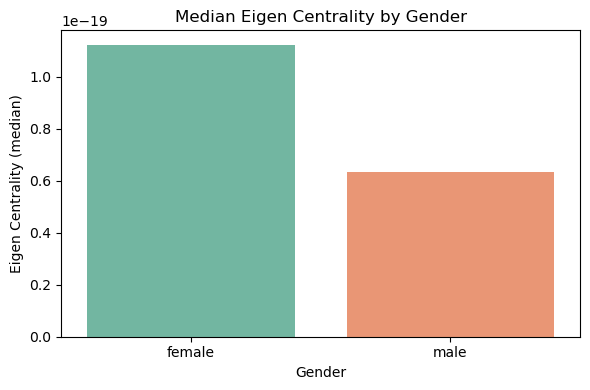

In [29]:
# Visualize the scores

data = {
    'gender': ['female', 'male'],
    'eigen_median': [1.122816e-19, 6.349403e-20]
}

df = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='gender', y='eigen_median', palette='Set2')

plt.title('Median Eigen Centrality by Gender')
plt.ylabel('Eigen Centrality (median)')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()

-> While the median scores of degree centrality are equal and the median scores of the betweenness centrality are zero, the median eigenvector centrality score for females is higher than that for the males. Mann-Whitney U test was conducted to determine whether the difference is statistically significant.  

In [30]:
male = people_df[people_df['gender'] == 'male']
female = people_df[people_df['gender'] == 'female']

for metric in ['eigen', 'degree', 'betweenness']:
    stat, p = mannwhitneyu(male[metric], female[metric], alternative='two-sided')
    result = "statistically significant ✅" if p < 0.05 else "statistically not significant ❌"
    print(f"{metric.upper()}: {result} (p = {p:.4f})")


EIGEN: statistically significant ✅ (p = 0.0034)
DEGREE: statistically not significant ❌ (p = 0.1082)
BETWEENNESS: statistically significant ✅ (p = 0.0061)


-> According to the Mann-Whitney U test result, the difference in eigenvector centrality score is statistically significant. This indicates that female board members have more direct connections with influential individuals than male board members.

# 5. Connectable Companies

< Identify key board members to make connections with acquired companies (M&A) >

In [31]:
# Identify board member names in both datasets of df_acquiring and people_df

# Preprocess name 

def preprocess_name(name):

    if pd.isna(name):

        return None
    
    name = name.lower().strip()

    for ch in ["’", "'", "`", "´", "‘"]:

        name = name.replace(ch, "'")

    name = ' '.join(name.split())
    
    return name

# Match names

board_member_cols = [f'Board Member {i}' for i in range(1, 23)]

all_board_members_list = []

for col in board_member_cols:

    if col in df_acquiring.columns:

        processed_names = df_acquiring[col].dropna().map(preprocess_name).tolist()

        all_board_members_list.extend(processed_names)

all_board_members = list(set([n for n in all_board_members_list if n]))

compensation_names = set(people_df['name'].map(preprocess_name))

common_members = [name for name in all_board_members if name in compensation_names]

not_in_compensation = [name for name in all_board_members if name not in compensation_names]

print("Members in the dataset of people_df:")
print(common_members)

Members in the dataset of people_df:
['arun sarin', 'donald e. graham', 'patricia f. russo', 'roderick c. mcgeary', 'ronald d. sugar', 'mercedes johnson', 'dina dublon', 'clarence otis jr.', 'shantanu narayen', 'suzanne m. vautrinot', 'andrea jung', 'david m. thomas']


-> These twelve key board members are in both datasets of df_acquiring and people_df.

In [32]:
names = ['david m. thomas', 'dina dublon', 'arun sarin', 'andrea jung', 'suzanne m. vautrinot', 'donald e. graham', 'clarence otis jr.', 'shantanu narayen', 'patricia f. russo', 'mercedes johnson', 'roderick c. mcgeary', 'ronald d. sugar']

upper_names = [name.upper() for name in names]

print(upper_names)

['DAVID M. THOMAS', 'DINA DUBLON', 'ARUN SARIN', 'ANDREA JUNG', 'SUZANNE M. VAUTRINOT', 'DONALD E. GRAHAM', 'CLARENCE OTIS JR.', 'SHANTANU NARAYEN', 'PATRICIA F. RUSSO', 'MERCEDES JOHNSON', 'RODERICK C. MCGEARY', 'RONALD D. SUGAR']


-> The result is the upper names of the key board members.

< Identify companies that the key board members may have connections >

In [33]:
# Filter rows in the people_df datset having the key board members' names

matched_df = people_df[people_df['name'].isin(upper_names)]

matched_df.head(10)


,name,eigen,degree,betweenness,is_person,age,compensation,gender,log_compensation,age_group,company_name
321,RONALD D. SUGAR,3.048083e-18,0.000244,0.001517,True,72,795626,male,5.900710,70s,AMGEN INC
322,RONALD D. SUGAR,3.048083e-18,0.000244,0.001517,True,72,795626,male,5.900710,70s,CHEVRON CORP
349,MERCEDES JOHNSON,3.573531e-20,0.000366,0.008230,True,70,662785,female,5.821373,70s,ANALOG DEVICES INC
350,MERCEDES JOHNSON,3.573531e-20,0.000366,0.008230,True,70,662785,female,5.821373,70s,MICRON TECHNOLOGY INC
351,MERCEDES JOHNSON,3.573531e-20,0.000366,0.008230,True,70,662785,female,5.821373,70s,"TERADYNE, INC"
385,ANDREA JUNG,1.529591e-20,0.000122,0.000000,True,66,425532,female,5.628933,60s,Apple Inc.
1331,SUZANNE M. VAUTRINOT,1.771907e-17,0.000244,0.005754,True,65,893469,female,5.951080,60s,CSX CORP
1332,SUZANNE M. VAUTRINOT,1.771907e-17,0.000244,0.005754,True,65,893469,female,5.951080,60s,ECOLAB INC.
2146,DONALD E. GRAHAM,6.048712e-18,0.000122,0.000000,True,79,0,male,0.000000,70s,Graham Holdings Co
2367,PATRICIA F. RUSSO,1.699353e-15,0.000244,0.002858,True,69,325000,female,5.511885,60s,Howmet Aerospace Inc.


-> The result shows key board members to contact and sell the company, as they are board members of big IT companies acquiring multiple IT companies. Based on their centrality scores, different approaches can be considered depending on situations. For example;

- MERCEDES JOHNSON has the highest betweeenness and degree centrality, indicating that she has broad netwroks and can play as a broker in her networks.
- SUZANNE M. VAUTRINOT has the highest eigenvector centrality, indicating that she has significant influence in decision-making.

In [34]:
board_member_cols = [f'Board Member {i}' for i in range(1, 23)]

# Make a list of key members

target_names = [
    'DAVID M. THOMAS', 'DINA DUBLON', 'ARUN SARIN', 'ANDREA JUNG',
    'SUZANNE M. VAUTRINOT', 'DONALD E. GRAHAM', 'CLARENCE OTIS JR.',
    'SHANTANU NARAYEN', 'PATRICIA F. RUSSO', 'MERCEDES JOHNSON',
    'RODERICK C. MCGEARY', 'RONALD D. SUGAR'
]

def normalize(name):

    if pd.isna(name):

        return None
    
    return name.strip().upper()

# Preprocess board member column

for col in board_member_cols:

    if col in df_acquiring.columns:

        df_acquiring[col] = df_acquiring[col].map(normalize)

results = []

# Check and match each row

for idx, row in df_acquiring.iterrows():

    company = row['Acquiring Company']
    members = [row[col] for col in board_member_cols if col in row]
    matched = list(set(members) & set(target_names))
    
    for person in matched:
        
        results.append({'Company': company, 'Board Member': person})

matched_df = pd.DataFrame(results)

matched_df.head(10)


,Company,Board Member
0,Apple,ANDREA JUNG
1,Apple,RONALD D. SUGAR
2,Cisco Systems,ARUN SARIN
3,Cisco Systems,RODERICK C. MCGEARY
4,Dell,SHANTANU NARAYEN
5,Facebook,DONALD E. GRAHAM
6,HP,PATRICIA F. RUSSO
7,IBM,DAVID M. THOMAS
8,Juniper Networks,MERCEDES JOHNSON
9,Microsoft,DINA DUBLON


-> The result shows the companies of the key board members.

In [35]:
target_companies = matched_df['Company'].unique().tolist()

filtered_df = df_acquiring[df_acquiring['Acquiring Company'].isin(target_companies)].copy()


members_by_company = (
    matched_df.groupby('Company')['Board Member']
    .apply(lambda names: ', '.join(sorted(set(names))))
    .reset_index()
    .rename(columns={'Company': 'Acquiring Company', 'Board Member': 'Board Members'})
)

merged_df = filtered_df.merge(members_by_company, on = 'Acquiring Company', how = 'left')

merged_df[['Acquiring Company', 'Number of Acquisitions', 'Acquired Companies', 'Board Members']].head(12)


,Acquiring Company,Number of Acquisitions,Acquired Companies,Board Members
0,Apple,51,"AlgoTrim, Anobit Technologies, AuthenTec, Beat...","ANDREA JUNG, RONALD D. SUGAR"
1,Cisco Systems,162,"Active Voice Corporation, Actona Technologies,...","ARUN SARIN, RODERICK C. MCGEARY"
2,Dell,26,"Acs (UK), Alienware, AppAssure Software, ASAP ...",SHANTANU NARAYEN
3,Facebook,49,"Atlas Advertiser Suite, Beluga, Bolt | Peters,...",DONALD E. GRAHAM
4,HP,88,"3Com, 3PAR, ABB CADE, Apollo Computer, AppIQ, ...",PATRICIA F. RUSSO
5,IBM,121,"Access360, Algorithmics, AlphaBlox Corporation...",DAVID M. THOMAS
6,Juniper Networks,10,"Altor Networks, Ankeena Networks, Blackwave, C...",MERCEDES JOHNSON
7,Microsoft,136,"90 Degree Software, ActiveViews, AdECN, Alacri...",DINA DUBLON
8,Symantec,17,"@Stake, AppStream, Brightmail, Clearwell Syste...",SUZANNE M. VAUTRINOT
9,Verizon Communications,7,"Alltel, CloudSwitch, EdgeCast Networks, Hughes...",CLARENCE OTIS JR.


-> The result exhibits lists of acquired companies across the big IT companies. The key board members may lead to connections with the acquried companies that are potential buyers. 

In [36]:
company_name = "Apple"

print(merged_df[merged_df['Acquiring Company'] == company_name]['Acquired Companies'].values[0])


AlgoTrim, Anobit Technologies, AuthenTec, Beats Electronics, Booklamp, Burstly, Chomp, Color Labs Inc., Concept.io, Coral Software, Cue, Emagic, Embark, Fingerworks, HopStop.com, imsense, Intrinsity, Lala, Locationary, LuxVue Technology, Matcha, Nashoba Systems, NetSelector, Network Innovations, NeXT, NeXT Computer, Nothing Real, Novauris, Orion Network Systems, PA Semi, Particle, Passif Semiconductor, Placebase, Polar Rose, Poly9, PowerSchool, PrimeSense, Propel Software, Proximity, Quattro Wireless, Raycer Graphics, Silicon Color, Siri, SnappyLabs, Spotsetter, Spruce Technologies, Styleware, Topsy Labs, WiFiSLAM, Xemplar Education, Zayante


-> To take an example, this result shows the names of all companies acquaired by Apple

In [37]:
key_board_members = [
    "ANDREA JUNG", "RONALD D. SUGAR",
    "ARUN SARIN", "RODERICK C. MCGEARY",
    "SHANTANU NARAYEN",
    "DONALD E. GRAHAM",
    "PATRICIA F. RUSSO",
    "DAVID M. THOMAS",
    "MERCEDES JOHNSON",
    "DINA DUBLON",
    "SUZANNE M. VAUTRINOT",
    "CLARENCE OTIS JR."
]

filtered_members = people_df[people_df['name'].isin(key_board_members)].drop_duplicates(subset=['name'])

filtered_members[['name', 'eigen', 'degree', 'betweenness']]

,name,eigen,degree,betweenness
321,RONALD D. SUGAR,3.048083e-18,0.000244,0.001517
349,MERCEDES JOHNSON,3.573531e-20,0.000366,0.008230
385,ANDREA JUNG,1.529591e-20,0.000122,0.000000
1331,SUZANNE M. VAUTRINOT,1.771907e-17,0.000244,0.005754
2146,DONALD E. GRAHAM,6.048712e-18,0.000122,0.000000
2367,PATRICIA F. RUSSO,1.699353e-15,0.000244,0.002858
2491,DAVID M. THOMAS,4.146320e-20,0.000122,0.000000
3422,RODERICK C. MCGEARY,8.853656e-18,0.000244,0.004076
3473,DINA DUBLON,4.160924e-20,0.000122,0.000000
3490,SHANTANU NARAYEN,9.842722e-21,0.000122,0.000000


-> The result exhibits expected roles of each key board member based on their centrality. For example, PATRICIA F. RUSSO has the highest eigenvector centrality. MERCEDES JOHNSON has the highest degree centrality and MERCEDES JOHNSON has the highest betweenness centrality.

# 6. Clustering Analysis

### 6.1. Cluster board members into groups

In [38]:
robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen', 'betweenness']])

In [39]:
dbscan = DBSCAN(eps = 0.4, min_samples = 15)  
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()

cluster_id
 0    2527
-1    1326
 1     350
 5     117
 2      88
 3      38
 4      22
 6      16
Name: count, dtype: int64

-> Eight groups were created with one noise group.

<Axes: xlabel='age', ylabel='log_compensation'>

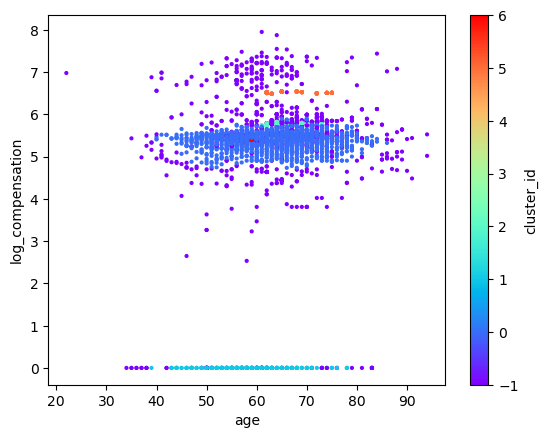

In [40]:
# Visualize culstering outcomes

people_df.plot.scatter(x = 'age', y = 'log_compensation', c = 'cluster_id', cmap = "rainbow", s = 4)

In [41]:
# Conduct silhouette test (do not include noise cluster) 

mask = people_df['cluster_id'] != -1

sil_score = silhouette_score(age_and_demographics_scaled[mask], people_df.loc[mask, 'cluster_id'])
print(f"DBSCAN Clustering Silhouette Score : {sil_score:.4f}")


DBSCAN Clustering Silhouette Score : 0.5292


-> According to the silhouette test result, the board members are fairly well separated.

### 6.2. Analyze centrality of groups

In [42]:
cluster_analysis = (
    people_df[people_df['cluster_id'] != -1]
    .groupby('cluster_id')
    .agg({
        'age': 'mean',
        'compensation': 'mean',
        'log_compensation': 'mean',
        'degree': 'mean',
        'eigen': 'mean',
        'betweenness': 'mean',
        'name': 'count'
    })
    .rename(columns = {'name': 'number of members'})
    .reset_index()
)

cluster_analysis

,cluster_id,age,compensation,log_compensation,degree,eigen,betweenness,number of members
0,0,63.657301,2.711466e+05,5.404111,0.000122,5.068407e-07,0.000000e+00,2527
1,1,58.128571,0.000000e+00,0.000000,0.000122,1.041856e-06,0.000000e+00,350
2,2,66.340909,6.046144e+05,5.777811,0.000244,2.228505e-14,3.081008e-03,88
3,3,64.105263,3.087645e+05,5.484691,0.000244,4.489850e-16,1.840731e-03,38
4,4,64.454545,3.239697e+05,5.508636,0.000244,3.707665e-13,3.632685e-03,22
5,5,67.777778,3.266732e+06,6.513772,0.001585,1.024389e-01,1.394057e-07,117
6,6,58.250000,2.468022e+05,5.390185,0.000244,4.070663e-08,2.586000e-03,16


-> This result summarizes the features of each group, except for the noise group. 

- cluster 5: board members in this group have the highest degree and eigenvector centrality, indicating broad networks and connections with influential individuals
- cluster 2, 3, 4, 6: board members in these groups can play as brokers
- cluster 0, 1: board members in these groups are general members with low inlfuence in their networks

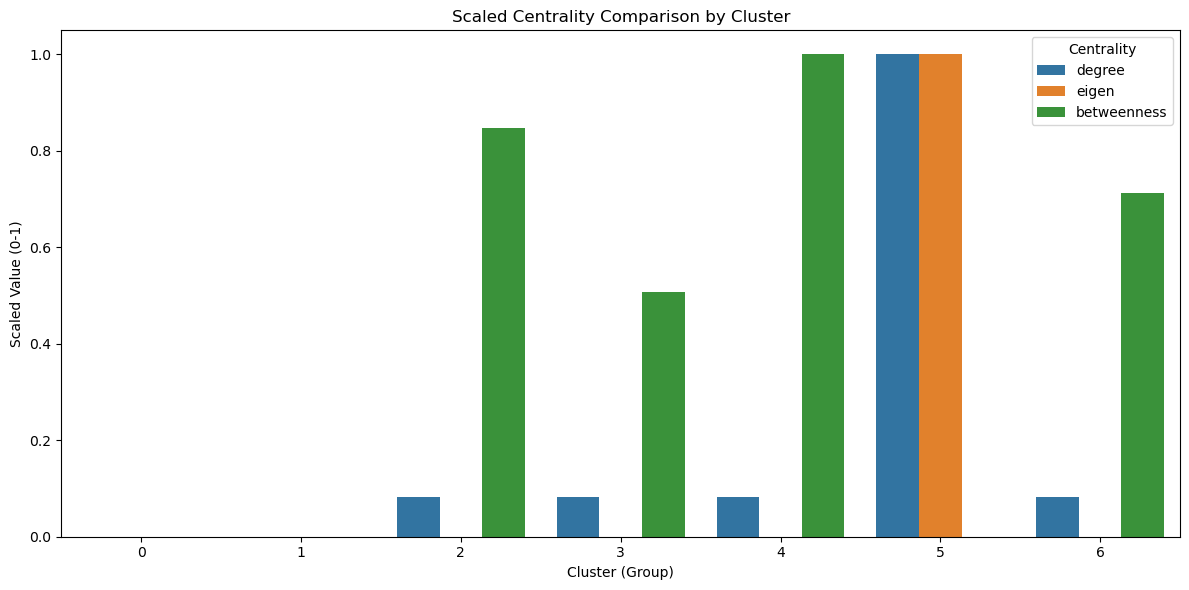

In [43]:
# Scale the three centrality measures 

centrality_cols = ['degree', 'eigen', 'betweenness']
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(cluster_analysis[centrality_cols])

# Make a dataframe with the scaled centrality measures

scaled_df = cluster_analysis[['cluster_id']].copy()
scaled_df[centrality_cols] = scaled_values

# Visualize the scaled centrality measures

melted = pd.melt(
    scaled_df,
    id_vars='cluster_id',
    value_vars=centrality_cols,
    var_name='centrality',
    value_name='scaled_value'
)

plt.figure(figsize = (12, 6))
sns.barplot(data = melted, x = 'cluster_id', y = 'scaled_value', hue = 'centrality')
plt.title("Scaled Centrality Comparison by Cluster")
plt.ylabel("Scaled Value (0-1)")
plt.xlabel("Cluster (Group)")
plt.legend(title = 'Centrality')
plt.tight_layout()
plt.show()



# 7. Conclusion

This data analysis project was conducted to identify key board members who can support selling the company, Morris_Inc_PLC. There were two approaches identifying key board members.

- M&A approach:

    This analysis identified key board members from big IT companies acquiring multiple IT companies, indicating connections with the acquired companies that can be potential buyers. 

- Network centrality approach:

    Through analyzing three network centrality measures, this analysis identified the top 20 board members with the highest degree and eigenvector centrality. They have broad networks and significant influence in decision-makings based on connections with influential individuals. Also, it identified the top 20 board members with the highest betweenness centrality. They can play as brokers and they have significant influence in their networks. In addition, board members were grouped into distinct clusters that can be defined by centrality characteristics. The groups will offer various strategies depending on situations.

Furthermore, this analysis found three insights that are supportive in selecting board members to contact. When it comes to age, board members aged between 60 and 89 are likely to serve at more companies, suggesting more opportunities in broadening networks. Then, regarding gender, female board members have more direct connections with influential individuals, compared to male board members. Lastly, board members with high compensations tend to serve at more companies.